# Implementación de PCA


importe de librerías necesarias

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import time

# Carga de datos
data = pd.read_csv('data_cleaner1.csv')
X = data.drop(['AdoptionLikelihood'], axis=1)
y = data['AdoptionLikelihood'].astype(int)  # Asegura int para clasificación

# Split train/test estratificado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Tamaño train: {X_train.shape}, test: {X_test.shape}")
print(f"Distribución y_train: {y_train.value_counts(normalize=True)}")

Tamaño train: (1605, 19), test: (402, 19)
Distribución y_train: AdoptionLikelihood
0    0.671651
1    0.328349
Name: proportion, dtype: float64


Función General para Aplicar PCA y Entrenar/Evaluar


In [7]:
def aplicar_pca_y_evaluar(modelo, n_comp, X_train, X_test, y_train, y_test, scaler=None):
    start = time.time()

    # Estandarizar si se proporciona scaler
    if scaler:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    # Aplicar PCA solo en train
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Entrenar modelo en train PCA
    modelo.fit(X_train_pca, y_train)

    # Predicciones en test
    y_pred = modelo.predict(X_test_pca)

    # Probabilidades para ROC AUC
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test_pca)[:, 1]
    else:
        y_proba = modelo.decision_function(X_test_pca)

    # Métricas en test
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)
    elapsed = time.time() - start

    # Varianza explicada por PCA
    var_explained = np.sum(pca.explained_variance_ratio_)

    print(f"Varianza explicada por {n_comp} componentes: {var_explained:.3f}")
    print(f"Precisión (test): {precision:.3f}")
    print(f"Recall (test):    {recall:.3f}")
    print(f"Accuracy (test):  {accuracy:.3f}")
    print(f"ROC AUC (test):   {auc:.3f}")
    print(f"Tiempo:           {elapsed:.2f} s")

    return {
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'auc': auc,
        'time': elapsed,
        'var_explained': var_explained
    }

Aplicación a Random Forest (con PCA)

In [8]:
# Hiperparámetros óptimos de RF (de tu notebook original)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_features=5,
    min_samples_leaf=1,
    random_state=42
)

# Estandarizador (opcional para RF, pero útil con PCA)
scaler = StandardScaler()

# Evaluar RF con PCA (n_comp=16)
print("=== Random Forest con PCA (16 componentes) ===")
resultados_rf_pca = aplicar_pca_y_evaluar(
    rf_model, n_comp=16,
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test,
    scaler=scaler
)

=== Random Forest con PCA (16 componentes) ===
Varianza explicada por 16 componentes: 0.971
Precisión (test): 0.747
Recall (test):    0.515
Accuracy (test):  0.784
ROC AUC (test):   0.809
Tiempo:           1.33 s


Aplicación a SVM (con PCA)

In [9]:
# Hiperparámetros óptimos de SVM (de tu notebook original)
svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma=0.1,
    class_weight='balanced',
    probability=True,  # Para predict_proba
    random_state=42
)

# Estandarizador (requerido para SVM)
scaler_svm = StandardScaler()

# Evaluar SVM con PCA (n_comp=16)
print("=== SVM con PCA (16 componentes) ===")
resultados_svm_pca = aplicar_pca_y_evaluar(
    svm_model, n_comp=16,
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test,
    scaler=scaler_svm
)

=== SVM con PCA (16 componentes) ===
Varianza explicada por 16 componentes: 0.971
Precisión (test): 0.725
Recall (test):    0.758
Accuracy (test):  0.826
ROC AUC (test):   0.878
Tiempo:           1.09 s


Celda 5: Comparación de Resultados (RF vs SVM con PCA)

=== Comparación RF vs SVM con PCA ===
              Métrica  RF con PCA  SVM con PCA
0           Precision       0.747        0.725
1              Recall       0.515        0.758
2            Accuracy       0.784        0.826
3             ROC AUC       0.809        0.878
4          Tiempo (s)       1.328        1.094
5  Varianza Explicada       0.971        0.971


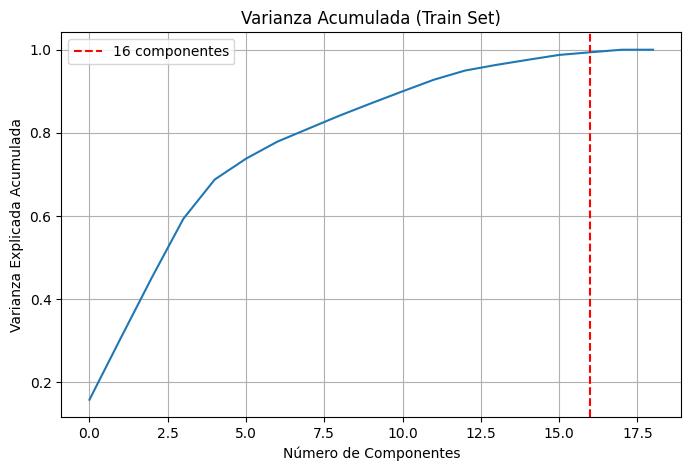

In [10]:
# Tabla comparativa
comparacion = pd.DataFrame({
    'Métrica': ['Precision', 'Recall', 'Accuracy', 'ROC AUC', 'Tiempo (s)', 'Varianza Explicada'],
    'RF con PCA': [
        resultados_rf_pca['precision'],
        resultados_rf_pca['recall'],
        resultados_rf_pca['accuracy'],
        resultados_rf_pca['auc'],
        resultados_rf_pca['time'],
        resultados_rf_pca['var_explained']
    ],
    'SVM con PCA': [
        resultados_svm_pca['precision'],
        resultados_svm_pca['recall'],
        resultados_svm_pca['accuracy'],
        resultados_svm_pca['auc'],
        resultados_svm_pca['time'],
        resultados_svm_pca['var_explained']
    ]
}).round(3)

print("=== Comparación RF vs SVM con PCA ===")
print(comparacion)

# Plot opcional: Varianza acumulada (de tu notebook original)
pca_full = PCA().fit(X_train)  # Solo para plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.axvline(x=16, color='r', linestyle='--', label='16 componentes')
plt.title('Varianza Acumulada (Train Set)')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.legend()
plt.grid()
plt.show()